# Проведение АВ теста


Цель: Нам нужно провести оценку результатов A/B-теста, проверить насколько тест соответствует техническому заданию, проанализировать результаты, чтобы понять позволил ли тест recommender_system_test увеличить конверсию в каждое событие на 10 п.п. и подготовить рекомендаци

**Техническое задание**
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
конверсии в просмотр карточек товаров — событие product_page,
просмотры корзины — product_cart,
покупки — purchase.

Ход работы:
- Изучение и предобработка данных;
- Оценка корректности теста;
- Исследовательский анализ данных;
- Оценка результатов A/B-тестирования;
- Выводы и рекомендации.


## Изучение данных

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

In [2]:
final_ab_events = pd.read_csv('final_ab_events.csv')
marketing_events = pd.read_csv('ab_project_marketing_events.csv')
new_users = pd.read_csv('final_ab_new_users.csv')
final_ab_participants = pd.read_csv('final_ab_participants.csv')

In [3]:
display(marketing_events.head())
display(new_users.head())
display(final_ab_events.head())
display(final_ab_participants.head())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


## Предоброботка данных

**Выполним предобработку для marketing_events**

In [4]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [6]:
marketing_events.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [7]:
marketing_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

Изменила типы данных в двух столбцах, дубликатов и пропусков не найдено

**Выполним предобработку для new_users**

In [8]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [9]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [10]:
new_users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [11]:
new_users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [12]:
new_users['user_id'].nunique()

61733

In [13]:
new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [14]:
new_users.duplicated().sum()

0

В одном столбце изменила тип данных, пропусков и дубликатов нет, в таблице предствалены данные о 61733 уникальном пользователе

**Выполним предобработку для final_ab_events**

In [15]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [16]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [17]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [18]:
final_ab_events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Много пропусков найдено в поле details, но details есть только у событий purchase (покупка), details показывает сумму покупки, у других событий этого столбца по логике быть не может. Как-то обработать эти пропуски мы не можем, удалить тоже нет, т.к. потеряется большой объем данных. Поэтому оставляем.

In [19]:
final_ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [20]:
new_users.duplicated().sum()

0

Изменила тип данных в одном столбце, найдены пропуски, но решено ничего с ними не делать, дубликатов не найдено

**Выполним предобработку для final_ab_participants**

In [21]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [22]:
final_ab_participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

In [23]:
final_ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [24]:
final_ab_participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [25]:
new_users.duplicated().sum()

0

Пропусков и дубликатов не найдено. Датасет состоит из 2 групп: А и В, а также из двух видов тестов.

## Оцените корректность проведения теста

Выделите пользователей участвующих в тесте и проверьте

### Период набора пользователей в тест и его соответствие требованиям технического задания

In [26]:
print('Первая дата регистрации',new_users['first_date'].min())
print('Последния дата регистрации', new_users['first_date'].max())

Первая дата регистрации 2020-12-07 00:00:00
Последния дата регистрации 2020-12-23 00:00:00


В ТЗ указано, что последний день добора новых пользователей 21.12.2023, но в датасете new_users данные о всех пользователях, поэтому проведем дополнительную проверку

In [27]:
recomm_user = final_ab_participants.query('ab_test == "recommender_system_test"')
recomm_user = new_users.merge(recomm_user, on='user_id')


In [28]:
print('Первая дата регистрации',recomm_user['first_date'].min())
print('Последния дата регистрации', recomm_user['first_date'].max())

Первая дата регистрации 2020-12-07 00:00:00
Последния дата регистрации 2020-12-21 00:00:00


В датасете new_users представлены данные все пользователей вне зависимости от участия в тесте. Мы соединили таблицы и увидели, что в тесте recommender_system_test последня дата регистрации участников 2020-12-21, что соответствует ТЗ

In [29]:
print('Дата запуска',final_ab_events['event_dt'].min())
print('Дата остановки', final_ab_events['event_dt'].max())

Дата запуска 2020-12-07 00:00:33
Дата остановки 2020-12-30 23:36:33


Также указано, что дата остановки теста 4.01.2021, в датасете последняя дата 30.12.2020

In [30]:
final_ab_participants.query("ab_test == 'recommender_system_test'").groupby('group')['user_id'].count()

group
A    3824
B    2877
Name: user_id, dtype: int64

Для теста recommender_system_test на самом деле есть две группы: А (контрольная) - 3824 пользователя, В (новая платежная воронка) 2877 пользователей

Предлагаю посмотреть сколько пользователей зарегистрировалось всего и после 21 декабря

In [31]:
print('Всего зарегистрированных пользователей',new_users['user_id'].nunique())

Всего зарегистрированных пользователей 61733


In [32]:
print('Всего новых пользователей, зарегистрированных после 21.12 - ',new_users.query('first_date > "2020-12-21"')['user_id'].nunique())

Всего новых пользователей, зарегистрированных после 21.12 -  5263


Пользователи после 21.12 нам не нужны. Удалим их из датафрейма

In [33]:
new_users = new_users.query('first_date >= "2020-12-07" and first_date <= "2020-12-21"')
new_users_eu = new_users.query('region == "EU"')
len(new_users)

56470

Создадим отдельную таблицу для теста recommender_system_test

In [34]:
participants_recom = final_ab_participants.query("ab_test == 'recommender_system_test'")

In [35]:
data1 = new_users_eu.merge(final_ab_participants, on = 'user_id')

In [36]:
participants_events = data1.merge(final_ab_events, on = 'user_id', how='left')

Мы соединили несколько датасетов, в итоге получили один с участниками теста, из Европы, с нужным периодом регистрации и с событиями

### Проверим сколько пользователей пересекаются в двух тестах

In [37]:
err_participants = (
                    participants_events
                               .groupby('user_id')
                               .agg({'ab_test': 'nunique'})
                               .reset_index()
                               .query('ab_test > 1')
                    )
print('Количество пользователей, участвующих в обоих тестрованиях - %s человека' % err_participants.shape[0])

Количество пользователей, участвующих в обоих тестрованиях - 1602 человека


In [38]:
#выделим этих пользователей в отдельный датасет
participants_new = participants_events[participants_events['user_id'].isin(err_participants['user_id'].values)]
participants_new['user_id'].nunique()

1602

In [39]:
participants_interface_B =  participants_new.query('ab_test == "interface_eu_test" & group =="B"')
print('Количество пользователей группы В параллельного теста - ', participants_interface_B['user_id'].nunique() )  

Количество пользователей группы В параллельного теста -  783


In [40]:
participants_interface_B = participants_events[participants_events['user_id'].isin(participants_interface_B['user_id'].values)]

In [41]:
participants_interface_B = participants_interface_B.query('ab_test == "recommender_system_test"')
participants_interface_B.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A          439
                        B          344

В тесте recommender_system_test в группе А учавствует 439 пользователей, которые одновременно были участниками теста interface_eu_test в группе В, а в группе В (recommender_system_test) -  344 пользователя. Это нехорошо, нужно проверить какую долю они занимают, что с ними делать. Для начала рассчитаю долю.

In [42]:
participants_recomm= participants_events.query('ab_test == "recommender_system_test"')
participants_recomm.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         3634
                        B         2717

Проведя несложные математические вычисления стало ясно, что доля участников из второго теста в группе **А = 12,08%**, а в группе **В = 12,66%**. Доля очень близкая, поэтому предлагаю участников не удалять, чтобы данных для теста было больше.

In [43]:
participants_recomm_A = participants_recomm.query('group == "A"')
participants_recomm_B = participants_recomm.query('group == "B"')

In [44]:
drop_list = list(participants_recomm_B['user_id'].unique())

In [45]:
df = participants_recomm_A.query('user_id in @drop_list')
df

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details


Пересечение не выявлено. Группы распределены корректно

### Проверим соблюдается ли условие - Аудитория: 15% новых пользователей из региона EU

In [46]:
eu_users = new_users[new_users['region'] == 'EU']['user_id'].nunique()
test_users = participants_recomm['user_id'].nunique()
print('Доля пользователей из EU - участников теста: {:.2%}'.format(test_users / eu_users))

Доля пользователей из EU - участников теста: 15.00%


### Посмотрим, на какой день жизни пользователи совершают событие

In [47]:
participants_recomm['delta'] = (participants_recomm['event_dt'] - participants_recomm['first_date']).dt.days

/var/folders/2b/g11mwp6d6rs813xd2mjgl07r9dw46l/T/ipykernel_958/2832619387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_recomm['delta'] = (participants_recomm['event_dt'] - participants_recomm['first_date']).dt.days


In [48]:
participants_recomm

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,delta
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,0.0
26,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN,NaN
44,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,0.0
45,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
102784,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN,4.0
102785,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN,0.0
102786,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN,1.0
102787,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:49,login,NaN,4.0


In [49]:
fig = px.bar(participants_recomm.groupby('delta')['event_name'].count().reset_index(), 
             x='delta', # указываем столбец с данными для оси X
             y='event_name', # указываем столбец с данными для оси Y
             text='event_name' 
            )
# оформляем график
fig.update_layout(title='День выполнения события',
                   xaxis_title='День',
                   yaxis_title='Количество событий')
fig.show() # выводим график

По графику видно, что в основном пользователи совершают событие в первые дни жизни в приложении. 

In [ ]:
participants_recomm['event_name'].isnull().sum() / len(participants_recomm['event_name']) *100

Почти 11% событий не зафиксировано

Отфильтруем по дельте события

In [ ]:
# отфильтруем те, которые в него не попадают
events = participants_recomm[participants_recomm['delta'] <=14].copy()
# посмотрим, сколько осталось событий
len(events)

22828

In [ ]:
user_group = events.groupby('group')['user_id'].nunique().reset_index()
user_group

,group,user_id
0,A,2604
1,B,877


In [ ]:
events['user_id'].nunique()

3481

**Вывод:** В датасете новые юзеры данные с 7.12 до 23.12, нам же по условию теста нужны пользователи только до 21.12, часть данных пришлось удалить. В таблице по событиям наоборот, некоторых не хватает данных с 31.12, хотя тесть по условию идет до 4.01. На данном этапе для теста recommender_system_test у меня есть две группы: А (контрольная) - 3824 пользователя, В (новая платежная воронка) 2877 пользователей. Таблицы я объединила. 

Далее из таблиц убрала все ненужные регионы, оставила только Европу. Нашла пересекающихся пользователей, которые попали и во второй тест, всего их было - 783, но их доля в двух группах нужного теста была очень близкой, следовательно и влияния они оказывали сопостовимое, поэтому я их не удаляла. 

Далее посмотрела как пользователи совершают события, в основном все события совершаются в первые дни жизни, но я решила оставить 14 дней, чтобы соответствовать условию теста. Но количество участников теста сократилось до 3481. В группе А - 2604 (75%), в группе В - 877 (25%). 

## Проведите исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?

Создадим отдельные датасеты для каждой из групп

In [ ]:
events_a = events.query('group == "A"')
events_b = events.query('group == "B"')

In [ ]:
print('На одного пользователя из группы А приходится', round(events_a['event_name'].count()/events_a['user_id'].nunique(),0), 'событий')
print('На одного пользователя из группы В приходится', round(events_b['event_name'].count()/events_b['user_id'].nunique(),0), 'событий')

На одного пользователя из группы А приходится 7.0 событий
На одного пользователя из группы В приходится 6.0 событий


События распределены неравномерно

### Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.

In [56]:
marketing_events_test = marketing_events.query('start_dt < "2021-01-04" and finish_dt > "2020-12-07"')
marketing_events_test.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В это время проводилось два мероприятия, но т.к. мы исследуем только пользователей из Европы, то только Christmas&New Year Promo могло повлиять на пользователей

In [57]:
events_b['event_name'].count()/events_b['user_id'].nunique()

5.531356898517674

### Как число событий в выборках распределено по дням?

In [58]:
events['event_dt'] = events['event_dt'].dt.date

In [59]:
d = events.groupby(['group','event_dt']).agg({'event_name': ['count'], 'user_id': ['nunique']}).reset_index()
d.columns = ['group','event_dt', 'event_name','user_id']
d['cnt_event'] = round(d['event_name']/d['user_id'],1)
d

,group,event_dt,event_name,user_id,cnt_event
0,A,2020-12-07,318,148,2.1
1,A,2020-12-08,313,147,2.1
2,A,2020-12-09,371,171,2.2
3,A,2020-12-10,331,156,2.1
4,A,2020-12-11,356,176,2.0
5,A,2020-12-12,346,168,2.1
6,A,2020-12-13,308,154,2.0
7,A,2020-12-14,1015,461,2.2
8,A,2020-12-15,1030,452,2.3
9,A,2020-12-16,1007,442,2.3


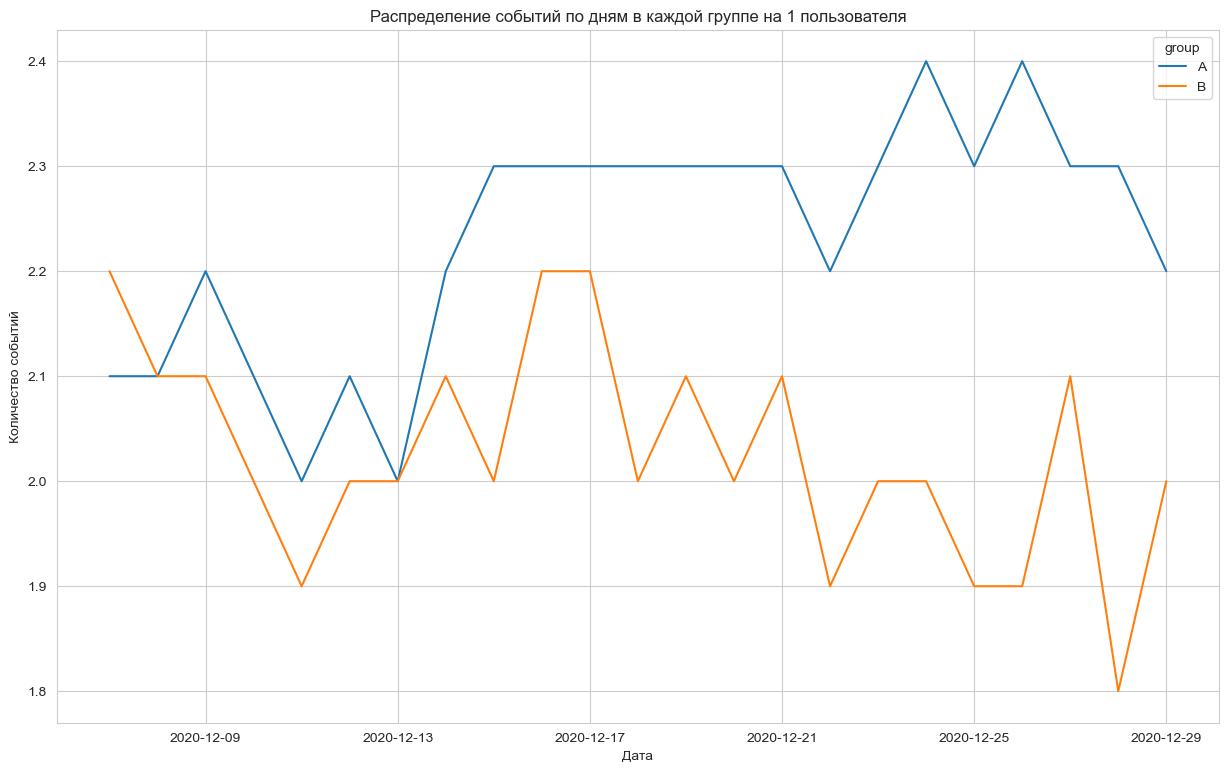

In [60]:
plt.figure(figsize=(15, 9)) # Важно! Этот код нужно писать до создания графика
sns.set_style("whitegrid")
ax = sns.lineplot(x='event_dt', y='cnt_event', hue='group', data=d)
ax.set_title('Распределение событий по дням в каждой группе на 1 пользователя')
ax.set_ylabel('Количество событий')
ax.set_xlabel('Дата')
plt.show()

По графику видно, что пользователи из группы А в среднем в день событий делали больше, чем пользователи из группы В. Особенно заметна разница после 22.12 у группы А кодичество событий увеличилось, у группы В начало снижаться

### Как меняется конверсия в воронке в выборках на разных этапах?

In [61]:
events_count = events['event_name'].value_counts().reset_index()
events_count.columns = ['event_name','count']
events_count

,event_name,count
0,login,10313
1,product_page,6382
2,purchase,3123
3,product_cart,3010


В корзину заходят реже, чем совершают покупки, это может быть связано с быстрой покупкой, такой как "купить в один клик"

In [62]:
fig = px.bar(events_count, 
             x='event_name', # указываем столбец с данными для оси X
             y='count', # указываем столбец с данными для оси Y
             text='count' 
            )
# оформляем график
fig.update_layout(title='Количество действий по событиям',
                   xaxis_title='Событие',
                   yaxis_title='Количество событий')
fig.show() # выводим график

In [63]:
events_uniq = events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
events_uniq['percent'] = round(events_uniq['user_id']/events['user_id'].nunique(),4)*100
events_uniq

,event_name,user_id,percent
0,login,3480,99.97
1,product_page,2178,62.57
2,purchase,1082,31.08
3,product_cart,1026,29.47


In [64]:
def new_table(df, i1, i2):
    a, b = df.iloc[i1, :].copy(), df.iloc[i2, :].copy()
    df.iloc[i1, :], df.iloc[i2, :] = b, a
    return df

new_table(events_uniq, 2, 3)

,event_name,user_id,percent
0,login,3480,99.97
1,product_page,2178,62.57
2,product_cart,1026,29.47
3,purchase,1082,31.08


In [65]:
fig = px.funnel(events_uniq, x='percent', y='event_name',  title='Воронка продаж')
fig.show()

Из всех пользователей 99.97% зарегистрировались, 62.57% дошли до карточки товара, 31.08% совершили покупку, 29.47% перешли в корзину

In [66]:
users_a = events.query('group == "A"')['user_id'].nunique()
events_a = events.query('group == "A"')
users_a

2604

In [67]:
users_b = events.query('group == "B"')['user_id'].nunique()
events_b = events.query('group == "B"')
users_b


877

In [68]:
events_uniq_A = events.query('group == "A"').groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
events_uniq_A['percent'] = round(events_uniq_A['user_id']/users_a,4)*100
events_uniq_A

,event_name,user_id,percent
0,login,2604,100.00
1,product_page,1685,64.71
2,purchase,833,31.99
3,product_cart,782,30.03


In [69]:
events_uniq_B = events.query('group == "B"').groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
events_uniq_B['percent'] = round(events_uniq_B['user_id']/users_b,4)*100
events_uniq_B

,event_name,user_id,percent
0,login,876,99.89
1,product_page,493,56.21
2,purchase,249,28.39
3,product_cart,244,27.82


In [70]:
events_uniq_B

,event_name,user_id,percent
0,login,876,99.89
1,product_page,493,56.21
2,purchase,249,28.39
3,product_cart,244,27.82


In [71]:
new_table(events_uniq_B, 2, 3)

,event_name,user_id,percent
0,login,876,99.89
1,product_page,493,56.21
2,product_cart,244,27.82
3,purchase,249,28.39


In [72]:
events_uniq_AB = events_uniq_A.merge(events_uniq_B, on='event_name')
events_uniq_AB.columns = ['event_name', 'user_id_a', 'percent_a', 'user_id_b', 'percent_b' ]
events_uniq_AB

,event_name,user_id_a,percent_a,user_id_b,percent_b
0,login,2604,100.00,876,99.89
1,product_page,1685,64.71,493,56.21
2,purchase,833,31.99,249,28.39
3,product_cart,782,30.03,244,27.82


In [73]:
events_uniq_A

,event_name,user_id,percent
0,login,2604,100.00
1,product_page,1685,64.71
2,purchase,833,31.99
3,product_cart,782,30.03


In [74]:
new_table(events_uniq_A, 2, 3)

,event_name,user_id,percent
0,login,2604,100.00
1,product_page,1685,64.71
2,product_cart,782,30.03
3,purchase,833,31.99


In [75]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'А',
    y = events_uniq_A['event_name'],
    x = events_uniq_A['user_id'],
    ))
fig.add_trace(go.Funnel(
    name = 'B',
    y = events_uniq_B['event_name'],
    x = events_uniq_B['user_id'],
    ))
fig.update_layout(
    title=go.layout.Title(
        text="Воронка продаж <br><sup>Распределенная по группам</sup>",
        xref="paper",
        x=0
    ))
fig.show()

**Вывод:** События на пользователя в каждой из групп распределены неравномерно, в группе А - 7 событий, в группе В - 6 событий. Также во время проведения теста проводилось два мероприятия, но т.к. мы исследуем только пользователей из Европы, то только Christmas&New Year Promo могло повлиять на пользователей.

Распределение событий по дням тоже неравномерное, мы видим, что в группе А после 12.12 был рост количества событий, в группе В рост был менее выражен, также в группе А наблюдается всплеск 21.12, в группе В он был совсем небольшой. Из всех пользователей 99.97% зарегистрировались, 62.57% дошли до карточки товара, 31.08% совершили покупку, 29.47% перешли в корзину


## Проведите оценку результатов A/B-тестирования:

### Что можно сказать про результаты A/B-тестирования?

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

конверсии в просмотр карточек товаров — событие product_page

просмотры корзины — product_cart

покупки — purchase.

In [76]:
results = events.groupby(['group', 'event_name'])['ab_test'].count().reset_index()
results

,group,event_name,ab_test
0,A,login,7968
1,A,product_cart,2385
2,A,product_page,5125
3,A,purchase,2499
4,B,login,2345
5,B,product_cart,625
6,B,product_page,1257
7,B,purchase,624


In [77]:
results_cr = pd.DataFrame(index=['product_cart', 'product_page', 'purchase'], \
                                 columns=['cr_a','cr_b','delta'])


In [78]:
for i in [1,2,3]:
    results_cr.iloc[i-1, 0] = round((results.iloc[i,2] / results.iloc[0,2] * 100), 1)   
for i in [1,2,3]:
    results_cr.iloc[i-1, 1] = round((results.iloc[i+4,2] / results.iloc[4,2] * 100), 1)    
results_cr['delta'] = (results_cr['cr_b'] / results_cr['cr_a'] * 100 - 100)

results_cr

,cr_a,cr_b,delta
product_cart,29.9,26.7,-10.702341
product_page,64.3,53.6,-16.640747
purchase,31.4,26.6,-15.286624


В группе В улучшений не было, конверсия только снизилась

### Проверьте статистическую разницу долей z-критерием.

H0 - нулевая гипотеза о том, что статистически значимых различий в долях между группами пользователей нет

H1 - альтернативная гипотеза о том, что есть статистические различия между долями групп пользователей

In [79]:
def z_test(df1, df2, event, alpha, n):  
 
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([users_a, 
                        users_b])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([events_a[events_a['event_name'] == event]['user_id'].nunique(), 
                        events_b[events_b['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    print(n_users[0], n_users[1])
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу, есть статистически значимых различия между долями')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий между долями нет ')

In [80]:
for event in ['product_page', 'product_cart', 'purchase']:
    z_test(events_a, events_b, event,.05, 3)
    print()

2604 877
Событие: product_page
p-значение:  6.942739359416805e-06
Отвергаем нулевую гипотезу, есть статистически значимых различия между долями

2604 877
Событие: product_cart
p-значение:  0.21469192029582396
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий между долями нет 

2604 877
Событие: purchase
p-значение:  0.04652482738393027
Не получилось отвергнуть нулевую гипотезу, статистически значимых различий между долями нет 



**Вывод:** Мы видим, что конверсия на всех этапах воронки только ухудшилась, ни о каких увеличениях на 10п.п. говорить не приходится. Нулевую гипотезу отвергли только на этапе карточки товара, на остальных этапах значимой разницы между долями нет.

## Вывод

Все условия теста не соблюдены. 
- Не все даты есть;
- Количество участников намного меньше, всего 3481 вместо 6000 пользователей;
- Во время теста проходила маркетинговая акция, которая тоже согла повлиять на результаты;
- Также параллельно проходил второй тест, пользователи которого участвовали и в нашем.
Уже можем делать вывод о том, что могут быть высокая погрешность и недостоверность данных

По результатам исследовательского анализа данных в группах разное количество участников, на группу А приходится 7 событий, на группу В всего 6. Из всех пользователей 99.97% зарегистрировались, 62.57% дошли до карточки товара, 31.08% совершили покупку, 29.47% перешли в корзину Конверсия в группе В на 10% не увеличилась, а только снизилась. По итогам стататистического анализа мы отвергли гипотезу о равенстве долей в событие карточка товара.

По итогам теста можно сказать, что тест провален.

## Рекомендации

Перед проведением теста нужно внимательнее готовится, проверять наличие паралелльных тестов и маркетинговых акций, запускать тест на равные группы.
